In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
os.environ['COBAYA_NOMPI'] = 'True'
from cobaya.yaml          import yaml_load_file
from cobaya.samplers.mcmc import plot_progress
#
from getdist.mcsamples    import MCSamplesFromCobaya
from getdist.mcsamples    import loadMCSamples
import getdist.plots      as     gdplt


from cobaya.model import get_model

sys.path.append('/global/cscratch1/sd/sfschen/BOSSxPlanck/')
sys.path.append('/global/cscratch1/sd/sfschen/BOSSxPlanck/emulator/')
sys.path.append('/global/cscratch1/sd/sfschen/BOSSxPlanck/rsd_likelihood/')
sys.path.append('/global/cscratch1/sd/sfschen/BOSSxPlanck/gxk_likelihood/')
#
import os

In [3]:
info = yaml_load_file("joint_z3_lcdm.yaml")
model = get_model(info)

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'stop_on_error']
[parameterization] *WARNING* There are repeated parameter labels: {'SN^{N3}': ['SN_NGCz3', 'SN_SGCz3']}
Loading Taylor series.
['z3'] ['/global/cscratch1/sd/sfschen/boss_data_renorm/xi/z3.xi']
['NGCz3', 'SGCz3'] ['/global/cscratch1/sd/sfschen/boss_data_renorm/pk/pk_NGC_z3.dat', '/global/cscratch1/sd/sfschen/boss_data_renorm/pk/pk_SGC_z3.dat']
We are here!


In [4]:
pars = {'H0': 71.957642,
 'omegam': 0.30624422,
 'logA': 2.7559452999999996,
 'b1_NGCz3': 1.2879399,
 'b2_NGCz3': -1.6734879,
 'bs_NGCz3': 2.6070984,
 'alpha0_NGCz3': 27.3449,
 'alpha2_NGCz3': -10.436179,
 'SN0_NGCz3': -718.57285,
 'SN2_NGCz3': -2354.3215,
 'alpha_x_NGCz3': -1.5083223999999997,
 'smag_NGCz3': 0.91977681,
 'b1_SGCz3': 1.3055484,
 'b2_SGCz3': 0.30626086,
 'bs_SGCz3': 0.52783089,
 'alpha0_SGCz3': 14.346956,
 'alpha2_SGCz3': -4.709547799999999,
 'SN0_SGCz3': -1445.2167,
 'SN2_SGCz3': -55322.03599999999,
 'alpha_x_SGCz3': 6.3628728,
 'smag_SGCz3': 0.98791825,
 'B1_z3': 1.5349626,
 'F_z3': 1.0959386,
 'M0_z3': 0.0023621726000000003,
 'M1_z3': -0.11851115,
 'Q0_z3': -0.005235214,
 'Q1_z3': 0.7994913}

In [52]:
model.likelihood.keys()

dict_keys(['joint_boss_likelihoods_emu_lnA.FullShapePlusBAOEmu_Z3', 'gxk_likelihood.GxKLikelihood'])

In [5]:
model.logposterior(pars)
glik = model.likelihood['gxk_likelihood.GxKLikelihood']
rlik = model.likelihood['joint_boss_likelihoods_emu_lnA.FullShapePlusBAOEmu_Z3']

In [94]:
dPs = {}
Fishers = {}

for lik in model.likelihood.keys():
    dPs[lik] = {}
    Fishers[lik] = {}

In [102]:
err = 0.05

for lik in model.likelihood.keys():
    
    for param_str in pars.keys():
        param = pars[param_str]
    
        pars_plus = pars.copy()
        pars_plus[param_str] = param + err
    
        pars_minus = pars.copy()
        pars_minus[param_str] = param - err

        model.logposterior(pars_plus)
        obs_plus = 1.0 * model.likelihood[lik].obs
        
        model.logposterior(pars_minus)
        obs_minus = 1.0 * model.likelihood[lik].obs
        
        dPs[lik][param_str] = (obs_plus - obs_minus)/(2*err)

In [103]:
for lik in model.likelihood.keys():
    
    print(lik)
    
    Fij = np.zeros( (len(pars.keys()),)*2 )
    
    for ii, param_ii in enumerate(pars.keys()):
        for jj, param_jj in enumerate(pars.keys()):
            
            Fij[ii,jj] = np.dot(dPs[lik][param_ii],\
                                np.dot(model.likelihood[lik].cinv,\
                                       dPs[lik][param_jj]))
            
    Fishers[lik] = np.array(Fij)
    
    
            

joint_boss_likelihoods_emu_lnA.FullShapePlusBAOEmu_Z3
gxk_likelihood.GxKLikelihood


In [104]:
Ftot = 0
for lik in model.likelihood.keys():
    print(lik)
    Ftot += Fishers[lik]

joint_boss_likelihoods_emu_lnA.FullShapePlusBAOEmu_Z3
gxk_likelihood.GxKLikelihood


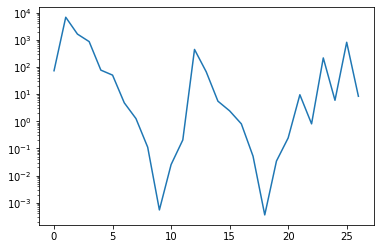

In [105]:
plt.semilogy(np.abs(Ftot[:,0]))

In [106]:
np.diag(np.linalg.inv(2*Ftot))**0.5

array([9.35860222e-01, 1.26248170e-02, 2.27434723e-01, 4.93969248e-01,
       5.13353343e+00, 8.18242288e+00, 8.28072222e+01, 7.10115021e+01,
       6.04222841e+03, 3.81974927e+04, 2.43129385e+01, 2.21805358e+00,
       4.13095740e-01, 7.02421171e+00, 9.83409886e+00, 1.16565126e+02,
       1.20803376e+02, 1.24498218e+04, 5.46287435e+04, 2.68167610e+01,
       2.52024985e+00, 3.60644792e-01, 3.65405628e-01, 8.44055053e-04,
       1.00121996e-01, 1.55088561e-03, 1.64485482e-01])